<a href="https://colab.research.google.com/github/alcarvalhox/Projeto-Eddy-Current/blob/master/EC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import math
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy import signal
from scipy.signal import medfilt
import seaborn as sns
import pywt
import csv

#################################################
from google.colab import drive
drive.mount("/content/drive/")

#################################################
try:
  path = '/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal'
  os.chdir(path)
except:
  print("Erro ao carregar diretorio no drive. Usado para drive compartilhado")

#################################################
print("Sistema preparado para rodar!")
print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sistema preparado para rodar!
19-08-2020 17:40:27


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Bloco de Classes**

In [53]:


#######################################
#### Leitura e Abertura de Arquivo ####
#######################################

class carrega_arquivo:
  def __init__(self):
    pass 

  def le_arquivo (self ,Path,File):
    #### Lê Arquivo .txt 
    with open(Path +'/'+ File, 'r') as f:
      # Usando a expressão regular para o separador indicando que eles são os espaços em branco
      df = pd.read_table(f, sep='\s+')
      df=df.replace(np.nan,0)
            

        # lista os cabeçalhos    
      cabecalho=df.columns

        # atribui a coluna do gráfico no indíce da coluna
      c = cabecalho[2]
        # define o comprimento da coluna
      a = len(df[cabecalho[2]])
        
        # cria vetor com quantidade de pontos
      x = np.arange(a)
        
        # define quantidade de linhas (pontos) e colunas
      linha = a
      coluna = 1
      
      return df[c]


##############################################################

#######################################
####        Filtra Sinais          ####
#######################################


class filtro:
  def __init__(self):
    pass

  def tira_spikes(self,teste):
    resultado = []
    grad = (np.gradient(teste))
    valores = [int(val) for val in grad]

    for x in range (1,len(teste)):
        resultado.append(teste[x])

    for x in range (1,len(teste)):
        if abs(valores[x]) > (200):
            for x in range (x,(x+500)):
                resultado[x]=0 # Sinal Original Filtrado 
                
    resultado=signal.medfilt(resultado,kernel_size=11) 
    
    return resultado

######################################################################

#######################################
####     Padronização do Sinal     ####
#######################################

class padroniza_sinal:
  def __init__(self):
    pass

  def padroniza(self,resultado) :
    media = np.mean(resultado)
    sinalpadrao = (resultado-media)/np.std(resultado) 
    return sinalpadrao

#########################################################################

#######################################
####         Plotar Gráficos       ####
#######################################


class ClassePlote:

  def __init__(self):
    pass


#########################################################
  # Função realiza o plote de vetor x e y
  # Parametros:
  # - VetorX
  # - VetorY
  # - Xlabel
  # - Ylabel
  # - legend 
#########################################################
  def ploteLinha(self, VetorX, VetorY, Xlabel, Ylabel, Legend):
    try:
      plt.plot(VetorX, VetorY) #, linestyle='--', color="k")  
      #plt.scatter(VetorX, VetorY, color="r", marker="o", label=Legend)     
      plt.xlabel(Xlabel)
      plt.ylabel(Ylabel)
      plt.title(Legend)
      plt.grid(False)
      plt.show()
    except:
      print("Erro no metodo ploteLinha: na Linha {}".format(sys.exc_info()[-1].tb_lineno))
    
    
#########################################################
#Função realiza o plote histograma 1D
# Parametros: 
#########################################################
  def plotHistograma1D(self, Dado, Nbins, BoolDensity, Xlabel, Ylabel, Legend):
    try:
      bins =  OperadorPlot.hist(Dado, Nbins, density=BoolDensity, label=Legend)
      OperadorPlot.xlabel(Xlabel)
      OperadorPlot.ylabel(Ylabel)
      OperadorPlot.legend()       
      OperadorPlot.grid(True)
      OperadorPlot.show()
    except:
        print("Erro no metodo plotHistograma1D: na Linha {}".format(sys.exc_info()[-1].tb_lineno))
    
    
#########################################################
#Função realiza o plote de vetor x e y
# Parametros: 
#########################################################
  def getRandomVector(self, lenght, mu, sigma): 
    try:
        return (mu + sigma * np.random.randn(lenght))
    except:
        print("Erro no metodo getRandomVector: na Linha {}".format(sys.exc_info()[-1].tb_lineno))




#########################################################################

#######################################
####         Identifica Threshold   ###
#######################################

class Ident_thres:
  def __init__(self):
    pass

  def threshold_sinal(self,opcao,amostras,sinalvet,limite):
    #%%%% a é o número de pontos do sinal
    #%%%% Delay são os número de pontos que irão retroagir
    #%%%% Amostras é o tamaho da janela dos sinais identificados
    #%%%% Limite é valor do threshlod para filtrar ruídos iniciais

    if opcao == 1:
        a1=delay + 30000 # + 3000 - RODO 
    else:
        a1=delay + 10000
        
    t=1  
    cont1=1
    janela=[]


    while (a1<(a-amostras)):
        if (abs(sinalvet[a1]) >= limite):

            #%%%% define a próxima janela a ser analisada
            janela.append(a1)
            a1=a1+amostras

        if (abs(sinalvet[a1]) < limite):

            #%%% desconsidera pontos abaixo do threshold e analisa o próximo ponto   
            a1=a1+1 

    return janela          







print("Classe carregada!")
print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

Classe carregada!
19-08-2020 20:01:41


# **Algoritmo Principal**

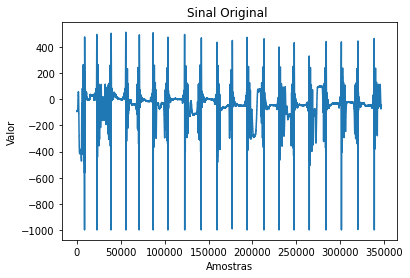

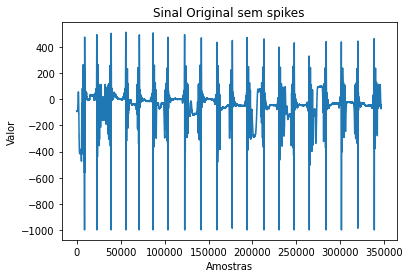

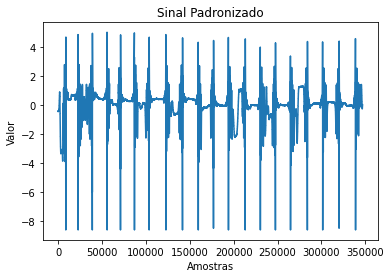

[13500, 23499, 33498, 43497, 53496, 67570, 77569, 87568, 99073, 109072, 119071, 129070, 139069, 149068, 159067, 173614, 191530, 201529, 211528, 227706, 237705, 247704, 263280, 273279, 283278, 299444, 309443, 319442]


In [57]:
Path = "/content/drive/My Drive/Projeto Eddy Current/Sinais_Coletados/Banco de Dados/Medidas_SVTS/JI"
File = "jti2_0.txt"


#########################
# Definição de Variáveis#
#########################
wavelet = 0 # Se = 1 realiza a transformada wavelet
opcao=2  #1=sinal rodo  2=sinal manual
mediasup = 4.15 #0.55
mediainf = -6.15 #-0.35
zerocross = 2
tipo_de_grafico = 'flag'
escalas = 512
familia=['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau8', 'shan', 'fbsp', 'cmor']
familia2=['cgau1','cgau2','cgau3','cgau4','cgau5','cgau6','cgau7','cgau8','cmor','fbsp','gaus1','gaus2','gaus3','gaus4','gaus5','gaus6','gaus7','gaus8','mexh','morl','shan']
nome_da_wavelet = familia2[8]
#gradiente =  29 # 1.45 #3 sd  #9 manual #1.45 rodo
path ='C:/Projeto Eddy Current/Supervisionado/Sinais/teste/imagem'

######################
# Opções de aquisição#
######################

if opcao == 1: # RODO 

    limite = 1 #4 #threshold superior
    limite2 = -200 #threshold inferior
    delay=800 #% RODO
    amostras=1499 # RODO
    const=20 # RODO
    gradiente = 1
    

if opcao == 2:# MANUAL 
   
    limite = 0.2 #1.8 #4 #0.7 (Junta) #threshold superior #0.7
    limite2 = -200 #threshold inferior
    delay=3500 #500 #250(Junta)Rodo # manual 40
    amostras=9999#7999 #2499 #799(Junta) #Rodo # manual 399
    const=20 #Rodo
    gradiente = 1

#######################################################################

### Cria Operador Arquivo
OperadorArquivos = carrega_arquivo()
### Recebe o arquivo lido
sinal=OperadorArquivos.le_arquivo(Path,File)

x1=list(range(1,(len(sinal)+1)))

### Cria Operador Filtro
OperadorFiltro=filtro()
### Recebe o arquivo sem spikes
resultado=OperadorFiltro.tira_spikes(sinal)

### Cria Operador Padroniza Sinal
OperadorPadroniza = padroniza_sinal()
### Recebe o arquivo do sinal padronizado
sinalpadrao=OperadorPadroniza.padroniza(resultado) 

x2=list(range(1,(len(sinalpadrao)+1)))

### Cria Operador Plota Sinal
OperadorPlota = ClassePlote()
### Plota gráfico
OperadorPlota.ploteLinha(x1,sinal,'Amostras','Valor','Sinal Original ')
OperadorPlota.ploteLinha(x2,resultado,'Amostras','Valor','Sinal Original sem spikes')
OperadorPlota.ploteLinha(x2,sinalpadrao,'Amostras','Valor','Sinal Padronizado')


### Cria Operador Threshold
OperadorThreshold = Ident_thres()
janela=OperadorThreshold.threshold_sinal(opcao,amostras,sinalpadrao,limite)

print(janela)

a=len(sinalpadrao)
sinalvet=sinalpadrao







